In [121]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

In [122]:
df_train = pd.read_csv('./data/forest-cover-type/train.csv', index_col=0 )
X_test = pd.read_csv('./data/forest-cover-type/test.csv', index_col=0 )

In [123]:
df_train

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2909,28,18,182,58,1350,210,197,117,2160,...,0,0,0,0,0,0,0,0,0,2
1,2757,334,30,212,83,1384,137,184,177,1570,...,0,0,0,0,0,0,0,0,0,2
2,3283,248,4,150,15,5601,211,243,170,892,...,0,0,0,0,0,0,1,0,0,1
3,3019,330,14,541,-101,1811,186,222,175,2154,...,0,0,0,0,0,0,0,0,0,2
4,3039,340,20,474,74,3407,175,207,169,1879,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2521,187,17,30,1,1099,220,250,158,1565,...,0,0,0,0,0,0,0,0,0,6
99996,2891,341,16,30,9,3774,186,215,167,2718,...,0,0,0,0,0,0,0,0,0,2
99997,2563,129,9,134,18,569,236,235,129,1293,...,0,0,0,0,0,0,0,0,0,2
99998,3322,238,14,153,32,2773,195,251,192,841,...,0,0,0,0,0,0,0,0,0,1


In [124]:
df_train.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

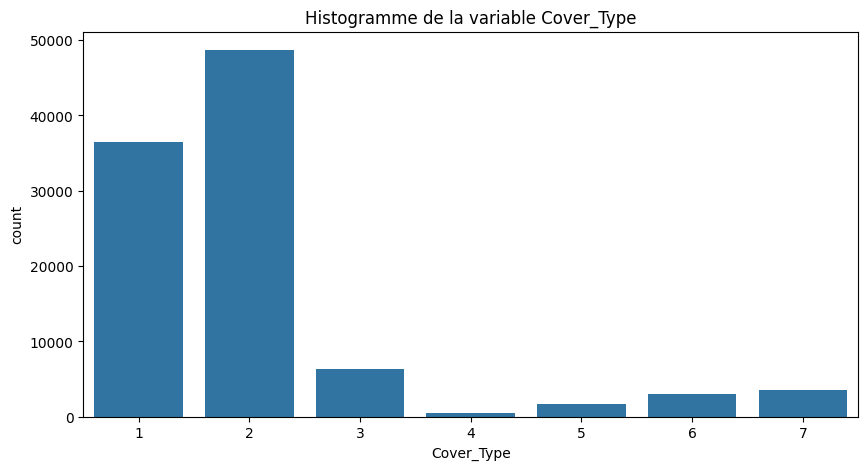

In [125]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Cover_Type', data=df_train)
plt.title(f"Histogramme de la variable Cover_Type")
plt.show()

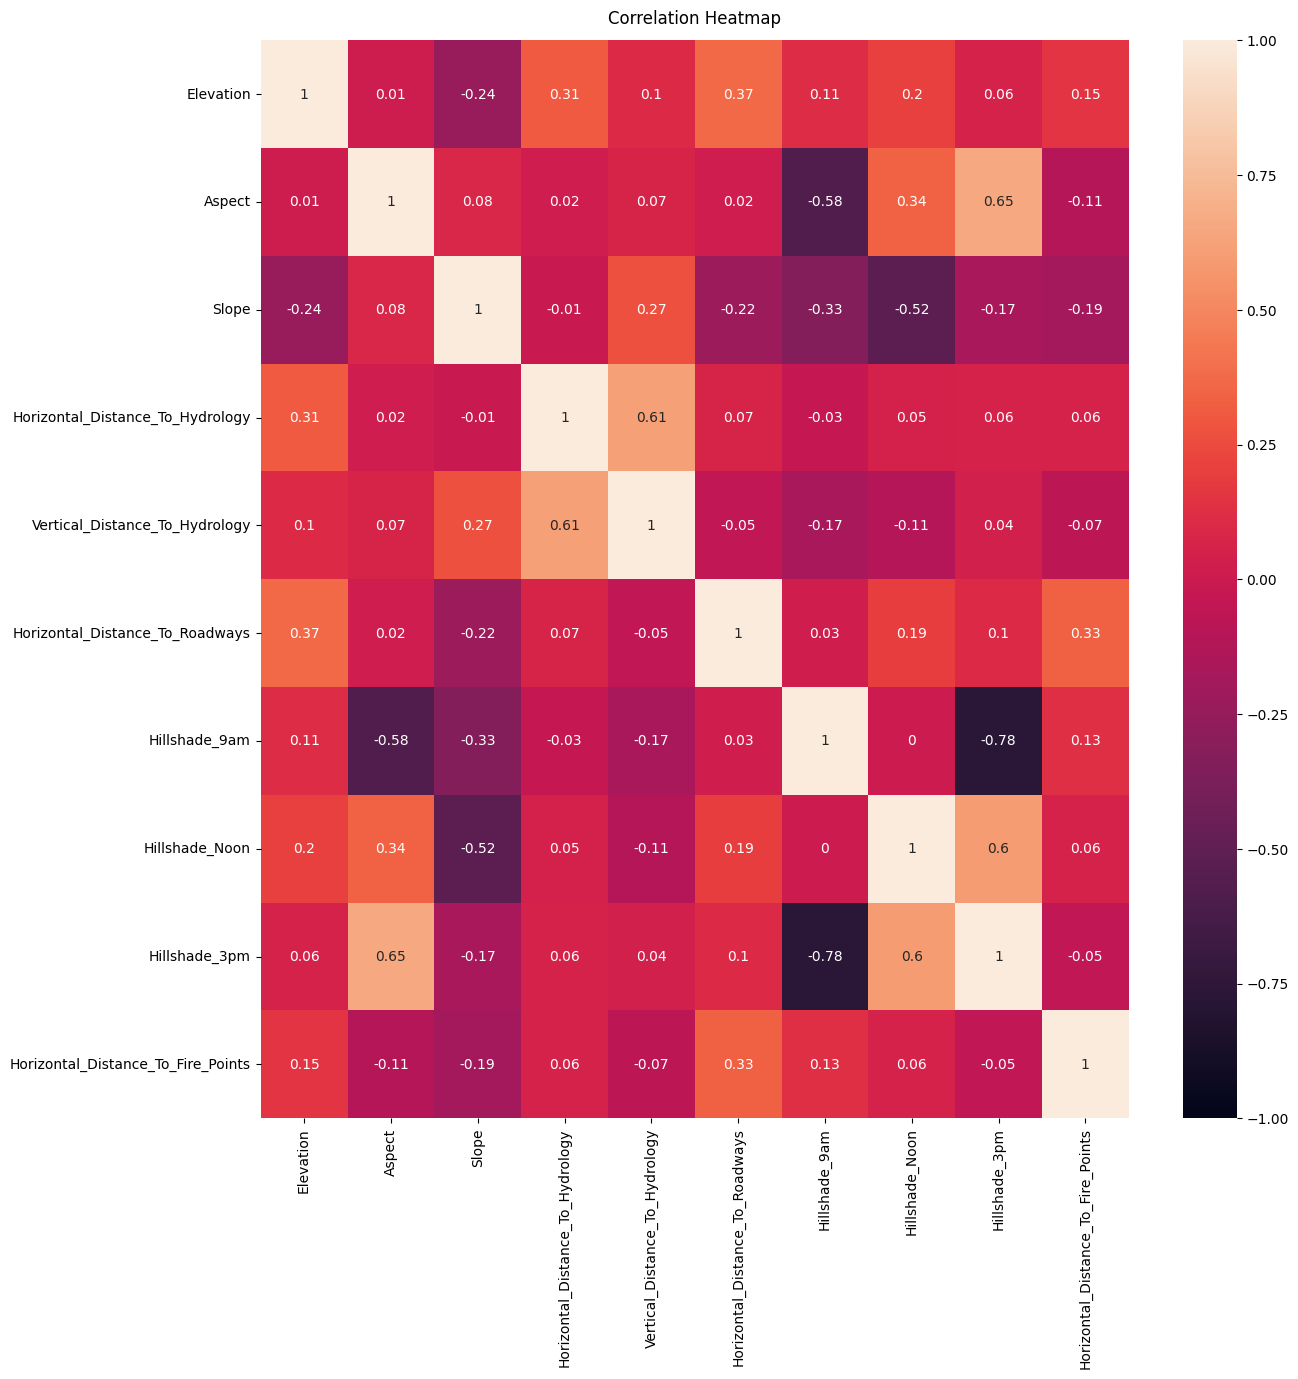

In [126]:
plt.figure(figsize=(14, 14))
df_cor = df_train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']]
# Calcul de la matrice de corrélation
correlation_matrix = df_cor.corr().round(2)

heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Répartition des données 

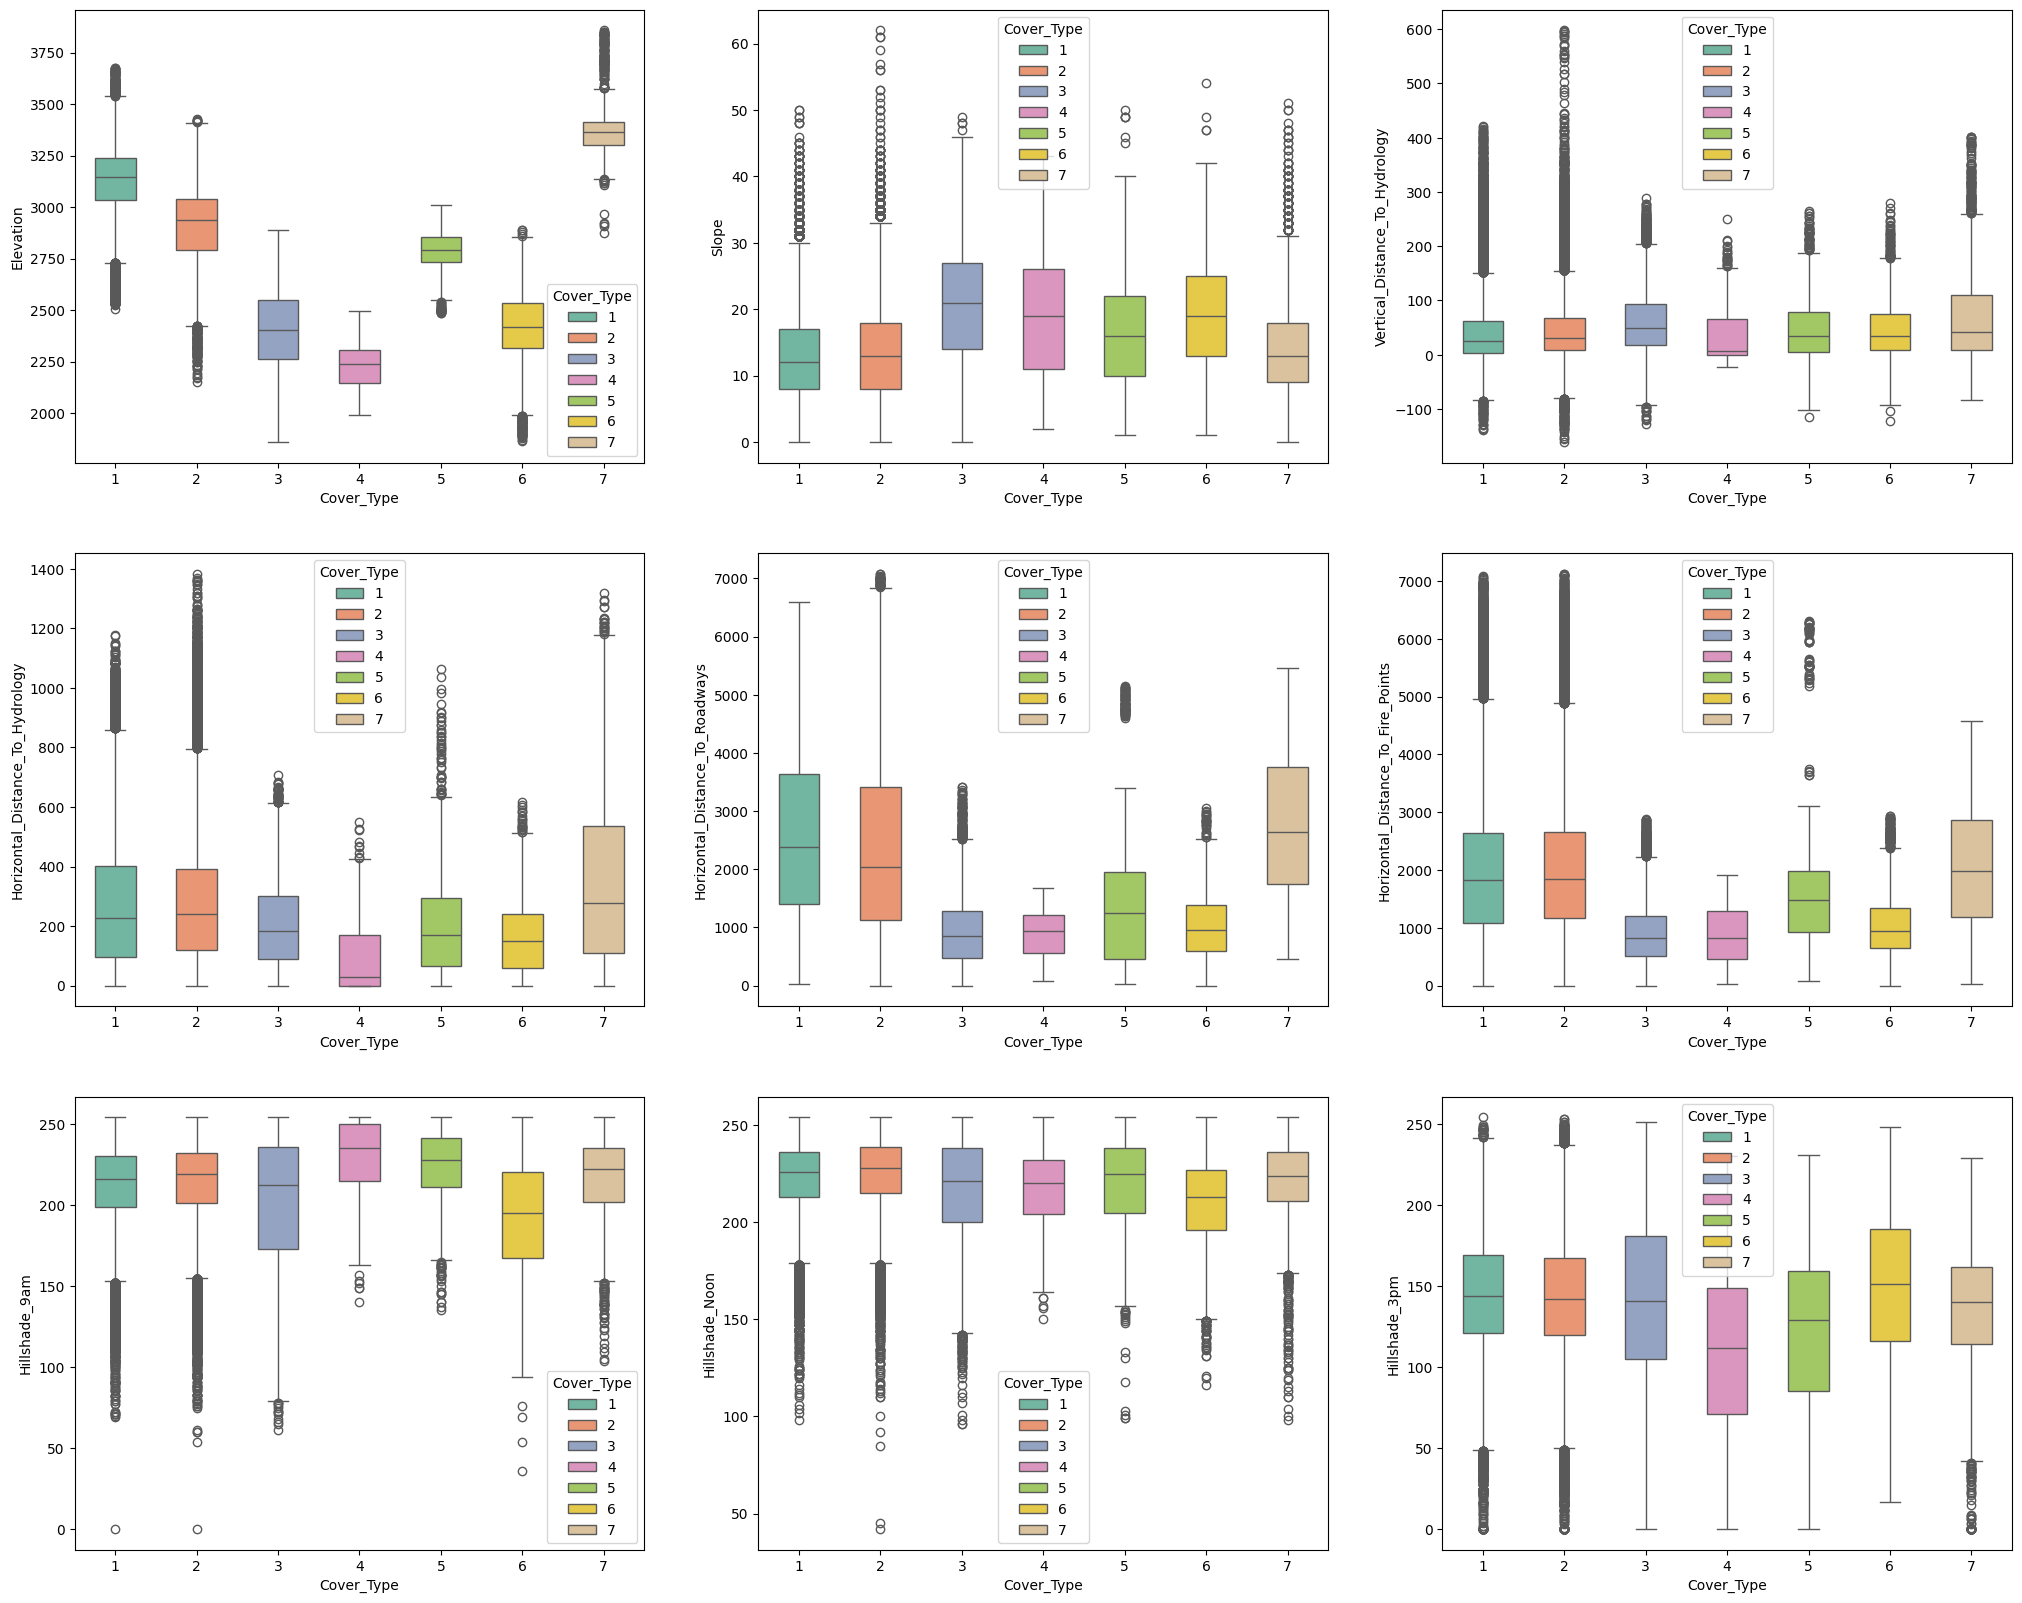

In [127]:
unique_values = df_train['Cover_Type'].nunique()  # Nombre de valeurs uniques de Cover_Type
cmap = sns.color_palette("Set2", unique_values)

def boxPlot(first_feature, sec_feature):
    sns.boxplot(x=first_feature, y=sec_feature, data=df_train, hue=first_feature,palette=cmap, width=0.5)

f = plt.figure(figsize=(25,20))
f.add_subplot(331)
boxPlot('Cover_Type','Elevation')
f.add_subplot(332)
boxPlot('Cover_Type','Slope')
f.add_subplot(333)
boxPlot('Cover_Type','Vertical_Distance_To_Hydrology')
f.add_subplot(334)
boxPlot('Cover_Type','Horizontal_Distance_To_Hydrology')
f.add_subplot(335)
boxPlot('Cover_Type','Horizontal_Distance_To_Roadways')
f.add_subplot(336)
boxPlot('Cover_Type','Horizontal_Distance_To_Fire_Points')
f.add_subplot(337)
boxPlot('Cover_Type','Hillshade_9am')
f.add_subplot(338)
boxPlot('Cover_Type','Hillshade_Noon')
f.add_subplot(339)
boxPlot('Cover_Type','Hillshade_3pm')

In [128]:
# valeurs égatives pour Vertical_Distance_To_Hydrology 
df_train['Vertical_Distance_To_Hydrology'] = abs(df_train['Vertical_Distance_To_Hydrology'] )

# Gestion des Outliers 

In [129]:
df_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [130]:
columns_to_keep = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# Appliquer sur tout le dataset
for column in columns_to_keep:
    df_train = handle_outliers(df_train, column)




# Séparation des données 

In [131]:
# separation des données
X = df_train.drop(columns=['Cover_Type'])
y = df_train['Cover_Type']

In [132]:
# divise les données 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scaling

In [133]:

columns_to_keep = ['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40']
columns_to_norm = [col for col in X.columns if col not in columns_to_keep]

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
# Normalisation sur l'ensemble d'entraînement
X_train_scaled[columns_to_norm] = scaler.fit_transform(X_train[columns_to_norm])

# Appliquer la même transformation sur l'ensemble de validation
X_val_scaled[columns_to_norm] = scaler.transform(X_val[columns_to_norm])


#données test 
X_test_scaled[columns_to_norm] = scaler.transform(X_test[columns_to_norm])

## Random Forest

In [134]:
classes = np.array([1, 2, 3, 4, 5, 6, 7])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
# Créez un modèle de forêt aléatoire
rf_model = RandomForestClassifier(class_weight=class_weights_dict)

# Entraînez le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_val)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.90
[[ 7955  1052     0     0     4     2    43]
 [  614 11517    43     0    24    35     3]
 [    0    68  1410    12     4    46     0]
 [    0     0    29    63     0     3     0]
 [    8   208     8     0   215     1     0]
 [    1    67   144     6     0   544     0]
 [  102    11     0     0     0     0   758]]
              precision    recall  f1-score   support

           1       0.92      0.88      0.90      9056
           2       0.89      0.94      0.92     12236
           3       0.86      0.92      0.89      1540
           4       0.78      0.66      0.72        95
           5       0.87      0.49      0.63       440
           6       0.86      0.71      0.78       762
           7       0.94      0.87      0.91       871

    accuracy                           0.90     25000
   macro avg       0.87      0.78      0.82     25000
weighted avg       0.90      0.90      0.90     25000

F1-score (pondéré) : 0.90


## KNN

In [135]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5, weights="distance")

# Entraînez le modèle sur l'ensemble d'entraînement
knn_model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = knn_model.predict(X_val)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.90
[[ 8133   844     0     0    15     2    62]
 [  718 11351    65     0    56    38     8]
 [    0    62  1368    22     4    84     0]
 [    0     0    23    58     0    14     0]
 [   11   107     6     0   315     1     0]
 [    1    44   120    10     3   584     0]
 [   69    11     0     0     0     0   791]]
              precision    recall  f1-score   support

           1       0.91      0.90      0.90      9056
           2       0.91      0.93      0.92     12236
           3       0.86      0.89      0.88      1540
           4       0.64      0.61      0.63        95
           5       0.80      0.72      0.76       440
           6       0.81      0.77      0.79       762
           7       0.92      0.91      0.91       871

    accuracy                           0.90     25000
   macro avg       0.84      0.82      0.83     25000
weighted avg       0.90      0.90      0.90     25000

F1-score (pondéré) : 0.90


# LDA

Variance expliquée par chaque composante de la LDA: [0.72787235 0.16669651 0.04957344 0.03062635 0.01619917 0.00903219]


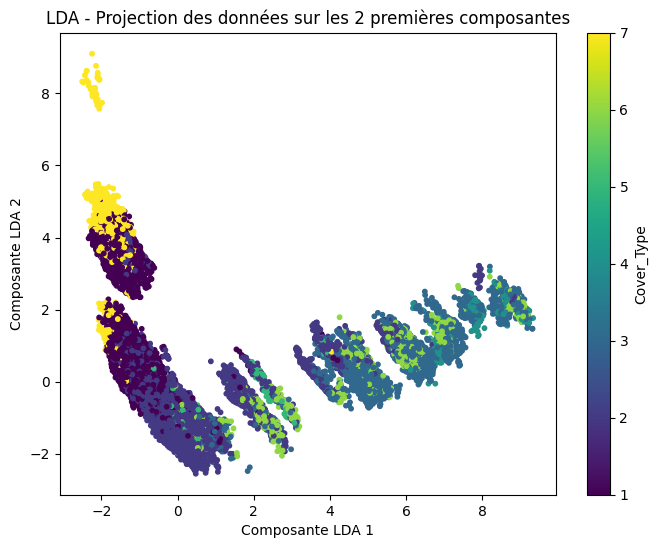

In [136]:
# appliquer lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# initialize the LDA
lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_val_lda = lda.transform(X_val_scaled)

# données test
X_test_lda = lda.transform(X_test_scaled)

# Afficher la variance expliquée par chaque composante de la LDA
print(f"Variance expliquée par chaque composante de la LDA: {lda.explained_variance_ratio_}")

# Visualiser les résultats de la LDA
plt.figure(figsize=(8, 6))
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('LDA - Projection des données sur les 2 premières composantes')
plt.xlabel('Composante LDA 1')
plt.ylabel('Composante LDA 2')
plt.colorbar(label='Cover_Type')
plt.show()

## Random Forest

In [137]:
from sklearn.model_selection import GridSearchCV
classes = np.array([1, 2, 3, 4, 5, 6, 7])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
# Créez un modèle de forêt aléatoire
rf_model = RandomForestClassifier(class_weight=class_weights_dict)

# Entraînez le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train_lda, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.82
[[ 7264  1683     2     0    10     6    91]
 [ 1357 10710    75     0    33    52     9]
 [    0    97  1305    20     6   112     0]
 [    0     0    54    37     0     4     0]
 [    9   247     9     0   174     1     0]
 [    1    94   245    11     0   411     0]
 [  185     8     0     0     0     0   678]]
              precision    recall  f1-score   support

           1       0.82      0.80      0.81      9056
           2       0.83      0.88      0.85     12236
           3       0.77      0.85      0.81      1540
           4       0.54      0.39      0.45        95
           5       0.78      0.40      0.52       440
           6       0.70      0.54      0.61       762
           7       0.87      0.78      0.82       871

    accuracy                           0.82     25000
   macro avg       0.76      0.66      0.70     25000
weighted avg       0.82      0.82      0.82     25000

F1-score (pondéré) : 0.82


## Gradient Boosting

In [138]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialisation et entraînement du modèle Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_lda, y_train)

# Prédiction sur l'ensemble de test
y_pred = gb_model.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.74
[[6586 2312    1    0    5    6  146]
 [2320 9714  111    1   25   59    6]
 [   0  154 1266   17    0  103    0]
 [   0    0   57   26    0   12    0]
 [   3  333   13    0   88    3    0]
 [   0  171  333   10    0  248    0]
 [ 292    2    0    0    0    0  577]]
              precision    recall  f1-score   support

           1       0.72      0.73      0.72      9056
           2       0.77      0.79      0.78     12236
           3       0.71      0.82      0.76      1540
           4       0.48      0.27      0.35        95
           5       0.75      0.20      0.32       440
           6       0.58      0.33      0.42       762
           7       0.79      0.66      0.72       871

    accuracy                           0.74     25000
   macro avg       0.68      0.54      0.58     25000
weighted avg       0.74      0.74      0.73     25000

F1-score (pondéré) : 0.73


## Regression Logistique Multivarée

In [139]:
from sklearn.linear_model import LogisticRegression
model_reglog = LogisticRegression(class_weight=class_weights_dict, max_iter=300)
model_reglog.fit(X_train_lda, y_train)
# Prédiction sur l'ensemble de test

y_pred = model_reglog.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.59
[[6015 1666    4    0  260   44 1067]
 [2762 6406  138    7 2327  498   98]
 [   0   11  712  232   71  514    0]
 [   0    0   13   68    0   14    0]
 [   7  110   14    0  303    6    0]
 [   0   32  151   73   49  457    0]
 [  97    0    0    0    2    0  772]]
              precision    recall  f1-score   support

           1       0.68      0.66      0.67      9056
           2       0.78      0.52      0.63     12236
           3       0.69      0.46      0.55      1540
           4       0.18      0.72      0.29        95
           5       0.10      0.69      0.18       440
           6       0.30      0.60      0.40       762
           7       0.40      0.89      0.55       871

    accuracy                           0.59     25000
   macro avg       0.45      0.65      0.47     25000
weighted avg       0.69      0.59      0.62     25000

F1-score (pondéré) : 0.62


## KNN

In [140]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")

# Entraîner le modèle SVM sur les données LDA réduites
knn.fit(X_train_lda, y_train)

# Prédictions sur les données de validation
y_pred = knn.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.83
[[ 7408  1520     2     0    13     7   106]
 [ 1293 10694    72     0    91    74    12]
 [    0    81  1251    35     9   164     0]
 [    0     0    38    45     0    12     0]
 [   13   164    12     0   250     1     0]
 [    2    64   210    11     4   471     0]
 [  122    12     0     0     1     0   736]]
              precision    recall  f1-score   support

           1       0.84      0.82      0.83      9056
           2       0.85      0.87      0.86     12236
           3       0.79      0.81      0.80      1540
           4       0.49      0.47      0.48        95
           5       0.68      0.57      0.62       440
           6       0.65      0.62      0.63       762
           7       0.86      0.85      0.85       871

    accuracy                           0.83     25000
   macro avg       0.74      0.72      0.73     25000
weighted avg       0.83      0.83      0.83     25000

F1-score (pondéré) : 0.83


### Recher hyperparamètres optimaux KNN

In [43]:
# Initialiser le modèle k-NN
knn = KNeighborsClassifier()

# Définir les hyperparamètres à tester
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Effectuer la Grid Search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train_lda, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Utiliser le meilleur modèle pour faire des prédictions sur les données de validation
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation accuracy: 0.8245523597926205
Exactitude du modèle : 0.83
[[ 7368  1552     1     0    14     7   114]
 [ 1282 10704    67     0    85    84    14]
 [    0    71  1292    15    12   150     0]
 [    0     0    35    50     0    10     0]
 [   20   172     9     0   236     3     0]
 [    3    75   188    10     3   483     0]
 [  117    14     0     0     0     0   740]]
              precision    recall  f1-score   support

           1       0.84      0.81      0.83      9056
           2       0.85      0.87      0.86     12236
           3       0.81      0.84      0.83      1540
           4       0.67      0.53      0.59        95
           5       0.67      0.54      0.60       440
           6       0.66      0.63      0.64       762
           7       0.85      0.85      0.85       871

    accuracy         

## SVM

In [104]:
from sklearn.svm import SVC

# Initialiser le modèle SVM avec un noyau RBF (ou un autre noyau si nécessaire)
svm_model = SVC( kernel='rbf', C=1, gamma='auto')

# Entraîner le modèle SVM sur les données LDA réduites
svm_model.fit(X_train_lda, y_train)

# Prédictions sur les données de validation
y_pred = svm_model.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")


Exactitude du modèle : 0.74
[[6505 2383    1    0    0    8  159]
 [2286 9770  105    0    6   66    3]
 [   0  137 1305   26    1   71    0]
 [   0    0   60   29    0    6    0]
 [   1  375   14    0   47    3    0]
 [   1  164  373    8    0  216    0]
 [ 334    2    0    0    0    0  535]]
              precision    recall  f1-score   support

           1       0.71      0.72      0.72      9056
           2       0.76      0.80      0.78     12236
           3       0.70      0.85      0.77      1540
           4       0.46      0.31      0.37        95
           5       0.87      0.11      0.19       440
           6       0.58      0.28      0.38       762
           7       0.77      0.61      0.68       871

    accuracy                           0.74     25000
   macro avg       0.69      0.52      0.55     25000
weighted avg       0.74      0.74      0.73     25000

F1-score (pondéré) : 0.73


### Recherche hyperparamètres optimaux SVM

In [17]:
### très très long
# Définir les paramètres à tester
param_grid = {
    'C': [10,30, 100],
    'gamma': [1, 10 ],
    'kernel': ['rbf', 'poly']
}

#Best parameters found: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
#Best cross-validation accuracy: 0.7585472444702385

# Initialiser le modèle SVM
svm = SVC(class_weight=class_weights_dict)

# Utiliser GridSearchCV pour trouver les meilleurs paramètres
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Entraîner GridSearchCV sur les données LDA réduites
#grid_search.fit(X_train_lda, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Utiliser le meilleur modèle pour faire des prédictions sur les données de validation
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_val_lda)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.5min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.5min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.5min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.5min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.6min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.6min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.6min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END ...................

/Users/elonalahmi/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 1.7min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 1.8min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.1min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.9min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.8min
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time= 2.0min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.8min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.9min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ...................

# ACP

Variance expliquée par chaque composante principale: [0.22917155 0.19333523 0.15756262 0.09838586 0.06771232 0.05117015
 0.04173005 0.03401634 0.02715184 0.02140922 0.011235   0.00761032
 0.00743075 0.00647575]


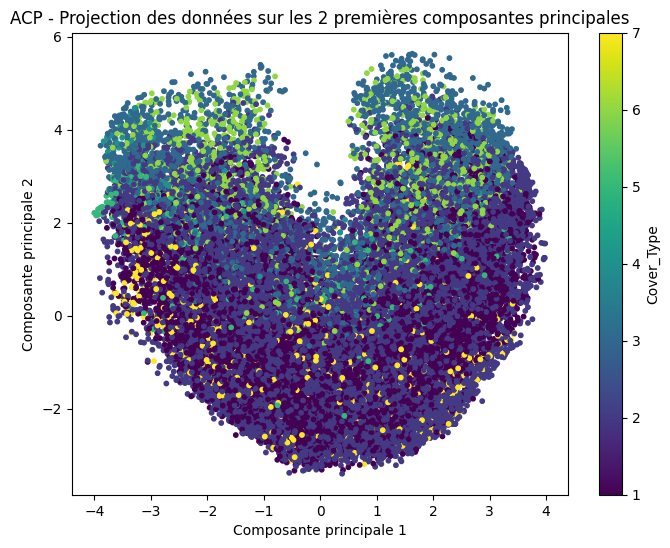

In [141]:
# Appliquer l'ACP
pca = PCA(n_components=0.95)  ## conserve 14 composantes : explique 95% de la variance 
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# données test
X_test_pca = pca.transform(X_test_scaled)

# Afficher la variance expliquée par chaque composante principale
print(f"Variance expliquée par chaque composante principale: {pca.explained_variance_ratio_}")

# Visualiser les résultats de l'ACP
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('ACP - Projection des données sur les 2 premières composantes principales')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cover_Type')
plt.show()

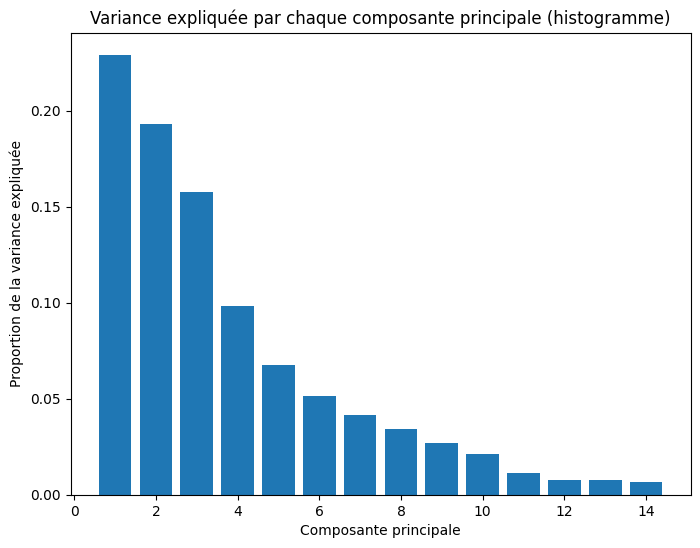

In [142]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.title('Variance expliquée par chaque composante principale (histogramme)')
plt.xlabel('Composante principale')
plt.ylabel('Proportion de la variance expliquée')
plt.show()


## Regression Logistique Multivariée

In [143]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression


classes = np.array([1, 2, 3, 4, 5, 6, 7])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

model_reglog = LogisticRegression(class_weight=class_weights_dict, max_iter=300)
model_reglog.fit(X_train_pca, y_train)
# Prédiction sur l'ensemble de test

y_pred = model_reglog.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.55
[[5582 1525    2    0  388   55 1504]
 [2744 5830  251    4 2627  525  255]
 [   0    6  723  249   97  465    0]
 [   0    0    7   77    0   11    0]
 [   6   68    4    2  340   20    0]
 [   0    5  163   85   24  485    0]
 [ 100    0    0    0    2    0  769]]
              precision    recall  f1-score   support

           1       0.66      0.62      0.64      9056
           2       0.78      0.48      0.59     12236
           3       0.63      0.47      0.54      1540
           4       0.18      0.81      0.30        95
           5       0.10      0.77      0.17       440
           6       0.31      0.64      0.42       762
           7       0.30      0.88      0.45       871

    accuracy                           0.55     25000
   macro avg       0.42      0.67      0.44     25000
weighted avg       0.68      0.55      0.59     25000

F1-score (pondéré) : 0.59


## Random Forest

In [144]:
from sklearn.model_selection import GridSearchCV
# Créez un modèle de forêt aléatoire
rf_model = RandomForestClassifier(class_weight=class_weights_dict)

# Entraînez le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train_pca, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.87
[[ 7754  1233     0     0     2     3    64]
 [  750 11348    69     1    17    43     8]
 [    0   151  1293    11     1    84     0]
 [    0     0    39    54     0     2     0]
 [   11   250     8     0   171     0     0]
 [    0   113   228     9     0   412     0]
 [  122    15     0     0     0     0   734]]
              precision    recall  f1-score   support

           1       0.90      0.86      0.88      9056
           2       0.87      0.93      0.90     12236
           3       0.79      0.84      0.81      1540
           4       0.72      0.57      0.64        95
           5       0.90      0.39      0.54       440
           6       0.76      0.54      0.63       762
           7       0.91      0.84      0.88       871

    accuracy                           0.87     25000
   macro avg       0.83      0.71      0.75     25000
weighted avg       0.87      0.87      0.87     25000

F1-score (pondéré) : 0.87


In [57]:
predictions = rf_model.predict(X_test_pca)

df_pred = pd.DataFrame(predictions, columns=["Cover_Type"]).reset_index().rename(columns={"index": "row_ID"})
display(df_pred.head(15))

df_pred.to_parquet("submission/forest-cover-type/RF_sub_1.parquet", index=False)

,row_ID,Cover_Type
0,0,2
1,1,2
2,2,3
3,3,2
4,4,3
5,5,2
6,6,2
7,7,1
8,8,2
9,9,1


### Recherche hypermaramètres optimaux Random Forest

In [ ]:
## 22 minutes 
param_grid = {
    'criterion':['gini','entropy'],
    'n_estimators': [100, 200, 300],           # Nombre d'arbres dans la forêt
    'max_depth': [20, 30, 40],                 # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],           # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4]              # Nombre minimum d'échantillons dans chaque feuille
}


# Créer le modèle de forêt aléatoire
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres avec validation croisée
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

# Entraîner la recherche sur les données d'entraînement
#grid_search.fit(X_train_pca, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour refaire des prédictions sur l'ensemble de test
best_rf_model = grid_search.best_estimator_

# Prédire sur l'ensemble de test
y_pred = best_rf_model.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")

# Afficher la matrice de confusion, le rapport de classification, et le F1-score
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Calculer le F1-score pondéré
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"F1-score (pondéré) : {f1:.2f}")

## KNN

In [145]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")

# Entraîner le modèle SVM sur les données LDA réduites
knn.fit(X_train_pca, y_train)

# Prédictions sur les données de validation
y_pred = knn.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.86
[[ 7699  1234     1     0    11     3   108]
 [  936 11025   100     4    71    85    15]
 [    0    91  1275    26     7   141     0]
 [    0     0    33    55     0     7     0]
 [   16   167     8     0   245     4     0]
 [    2    83   189    10     5   473     0]
 [  102    19     0     0     0     0   750]]
              precision    recall  f1-score   support

           1       0.88      0.85      0.86      9056
           2       0.87      0.90      0.89     12236
           3       0.79      0.83      0.81      1540
           4       0.58      0.58      0.58        95
           5       0.72      0.56      0.63       440
           6       0.66      0.62      0.64       762
           7       0.86      0.86      0.86       871

    accuracy                           0.86     25000
   macro avg       0.77      0.74      0.75     25000
weighted avg       0.86      0.86      0.86     25000

F1-score (pondéré) : 0.86


### Recherche hypermaramètres optimaux KNN

In [51]:
# Initialiser le modèle k-NN
knn = KNeighborsClassifier()

# Définir les hyperparamètres à tester
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Effectuer la Grid Search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Utiliser le meilleur modèle pour faire des prédictions sur les données de validation
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy: 0.8573732361986283
Exactitude du modèle : 0.87
[[ 7790  1132     1     0    18     8   107]
 [  954 11008    85     1    88    82    18]
 [    0    93  1263    26     6   152     0]
 [    0     0    26    62     0     7     0]
 [   11   153     8     0   264     4     0]
 [    8    76   157    15     4   502     0]
 [   88    16     0     0     0     0   767]]
              precision    recall  f1-score   support

           1       0.88      0.86      0.87      9056
           2       0.88      0.90      0.89     12236
           3       0.82      0.82      0.82      1540
           4       0.60      0.65      0.62        95
           5       0.69      0.60      0.64       440
           6       0.66      0.66      0.66       762
           7       0.86      0.88      0.87       871

    accuracy         

## Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialisation et entraînement du modèle Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_pca, y_train)

# Prédiction sur l'ensemble de test
y_pred = gb_model.predict(X_val_pca)

# Calcul de l'exactitude
accuracy = accuracy_score(y_val, y_pred)
print(f"Exactitude du modèle : {accuracy:.2f}")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

f1 = f1_score(y_val, y_pred, average='weighted')  # weighted gère les classes déséquilibrées
print(f"F1-score (pondéré) : {f1:.2f}")

Exactitude du modèle : 0.76
[[ 6755  2226     1     0     1     0    73]
 [ 1815 10201   114     4    22    76     4]
 [    0   297  1101    25     0   117     0]
 [    0     1    38    46     0    10     0]
 [   16   346     7     0    69     2     0]
 [    0   191   307     6     0   258     0]
 [  341     8     0     0     0     0   522]]
              precision    recall  f1-score   support

           1       0.76      0.75      0.75      9056
           2       0.77      0.83      0.80     12236
           3       0.70      0.71      0.71      1540
           4       0.57      0.48      0.52        95
           5       0.75      0.16      0.26       440
           6       0.56      0.34      0.42       762
           7       0.87      0.60      0.71       871

    accuracy                           0.76     25000
   macro avg       0.71      0.55      0.60     25000
weighted avg       0.76      0.76      0.75     25000

F1-score (pondéré) : 0.75
